## Run HMC using `tfp.mcmc.HamiltonianMonteCarloSampler`

In [1]:
%matplotlib notebook

In [43]:
import datetime
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from rich.console import Console
from rich.theme import Theme

sys.path.append('..')
sns.set_palette('bright')
%load_ext autoreload
%autoreload 2

console = Console(theme=Theme({"repr.number": "#ff79ff"}), width=240, log_time=True, log_time_format='[%X]')
#%matplotlib notebook
plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('bright')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using example from [tensorflow-probability](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo?version=nightly):

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp

# Target distribution is proportional to: `exp(-x (1 + x))`.
def unnormalized_log_prob(x):
  return -x - x**2.

# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=1.,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

  sample_mean = tf.reduce_mean(samples)
  sample_stddev = tf.math.reduce_std(samples)
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  return sample_mean, sample_stddev, is_accepted

sample_mean, sample_stddev, is_accepted = run_chain()

print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(
    sample_mean.numpy(), sample_stddev.numpy(), is_accepted.numpy()))

mean:-0.5088  stddev:0.7084  acceptance:0.7697


## MCMC

### Generate a dataset

In [4]:
# Generate some data
def f(x, w):
  # Pad x with 1's so we can add bias via matmul
  x = tf.pad(x, [[1, 0], [0, 0]], constant_values=1)
  linop = tf.linalg.LinearOperatorFullMatrix(w[..., np.newaxis])
  result = linop.matmul(x, adjoint=True)
  return result[..., 0, :]

num_features = 2
num_examples = 50
noise_scale = .5
true_w = np.array([-1., 2., 3.])

xs = np.random.uniform(-1., 1., [num_features, num_examples])
ys = f(xs, true_w) + np.random.normal(0., noise_scale, size=num_examples)

### Visualize the dataset

<IPython.core.display.Javascript object>


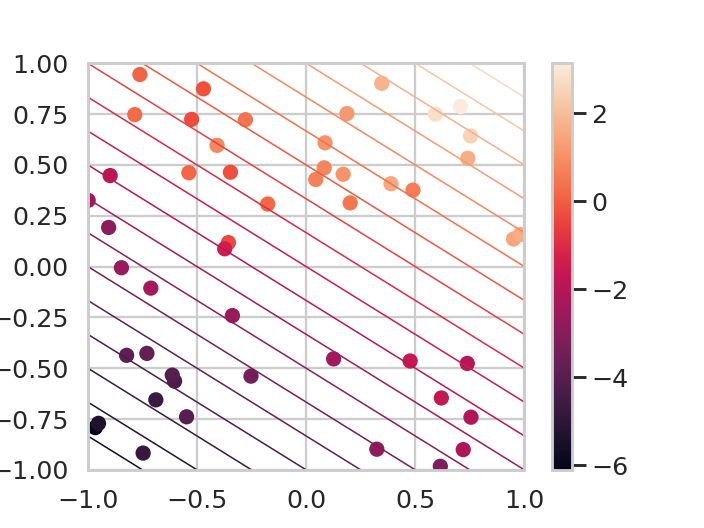

In [5]:
# Visualize the data set
plt.scatter(*xs, c=ys, s=100, linewidths=0)

grid = np.meshgrid(*([np.linspace(-1, 1, 100)] * 2))
xs_grid = np.stack(grid, axis=0)
fs_grid = f(xs_grid.reshape([num_features, -1]), true_w)
fs_grid = np.reshape(fs_grid, [100, 100])
plt.colorbar()
plt.contour(xs_grid[0, ...], xs_grid[1, ...], fs_grid, 20, linewidths=1)
plt.show()

### Define our joint log-prob function

In [6]:
# Create our unnormalized target density by currying x and y from the joint.
def unnormalized_posterior(w):
  return joint_log_prob(w, xs, ys)

In [8]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow_probability as tfp

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

num_features = 2

tfd = tfp.distributions
tfb = tfp.bijectors

def joint_log_prob(w, sigma, x, y):
  # Our model in maths is
  #   w ~ MVN([0, 0, 0], diag([1, 1, 1]))
  #   y_i ~ Normal(w @ x_i, noise_scale),  i=1..N

  rv_w = tfd.MultivariateNormalDiag(
    loc=np.zeros(num_features + 1),
    scale_diag=np.ones(num_features + 1))

  rv_sigma = tfd.LogNormal(np.float64(1.), np.float64(5.))

  rv_y = tfd.Normal(f(x, w), sigma[..., np.newaxis])
  return (rv_w.log_prob(w) +
          rv_sigma.log_prob(sigma) +
          tf.reduce_sum(rv_y.log_prob(y), axis=-1))

# Create our unnormalized target density by currying x and y from the joint.
def unnormalized_posterior(w, sigma):
  return joint_log_prob(w, sigma, xs, ys)


# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior,
  step_size=np.float64(.1),
  num_leapfrog_steps=4)



# Create a TransformedTransitionKernl
transformed_kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=hmc_kernel,
    bijector=[tfb.Identity(),    # w
              tfb.Invert(tfb.Softplus())])   # sigma


# Apply a simple step size adaptation during burnin
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
  adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
      transformed_kernel,
      num_adaptation_steps=int(.8 * num_burnin_steps),
      target_accept_prob=np.float64(.75))

  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_state,
    kernel=adaptive_kernel,
    seed=(0, 1),
    trace_fn=lambda cs, kr: kr)


# Instead of a single set of initial w's, we create a batch of 8.
num_chains = 8
initial_state = [np.zeros([num_chains, num_features + 1]),
                 .54 * np.ones([num_chains], dtype=np.float64)]

chains, kernel_results = run_chain(initial_state)

r_hat = tfp.mcmc.potential_scale_reduction(chains)
print("Acceptance rate:", kernel_results.inner_results.inner_results.is_accepted.numpy().mean())
print("R-hat diagnostic (per w variable):", r_hat[0].numpy())
print("R-hat diagnostic (sigma):", r_hat[1].numpy())

Acceptance rate: 0.751875
R-hat diagnostic (per w variable): [ 35.58406881  54.38445364 121.36449868]
R-hat diagnostic (sigma): 1.3127092062292312


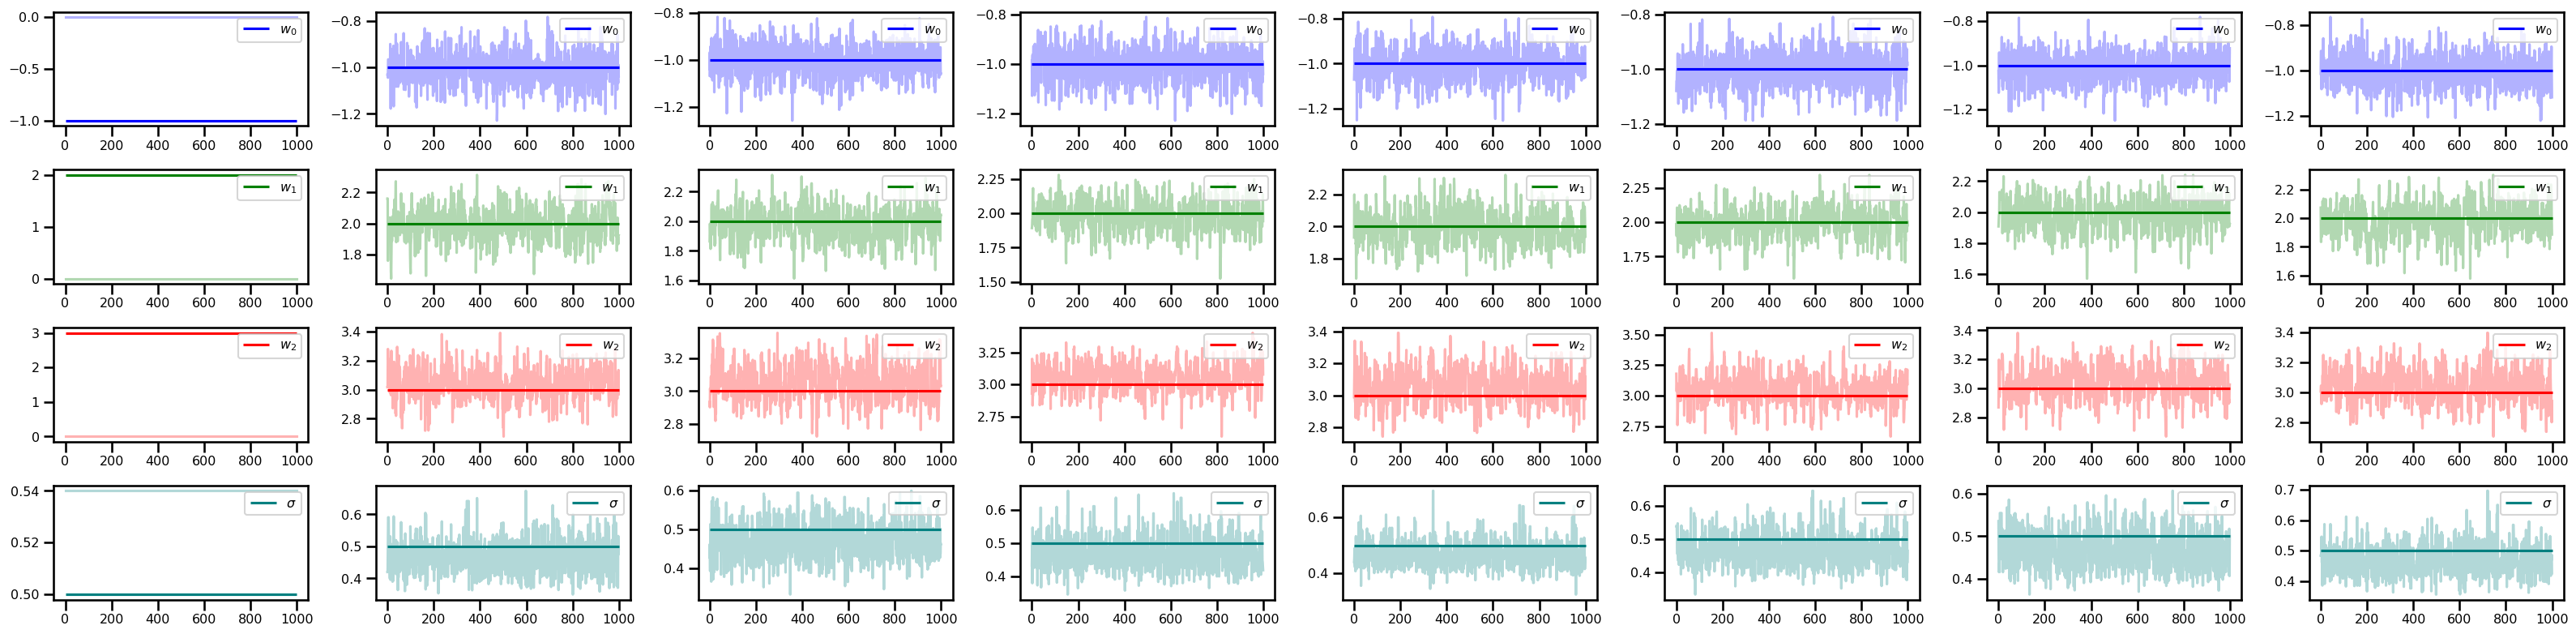

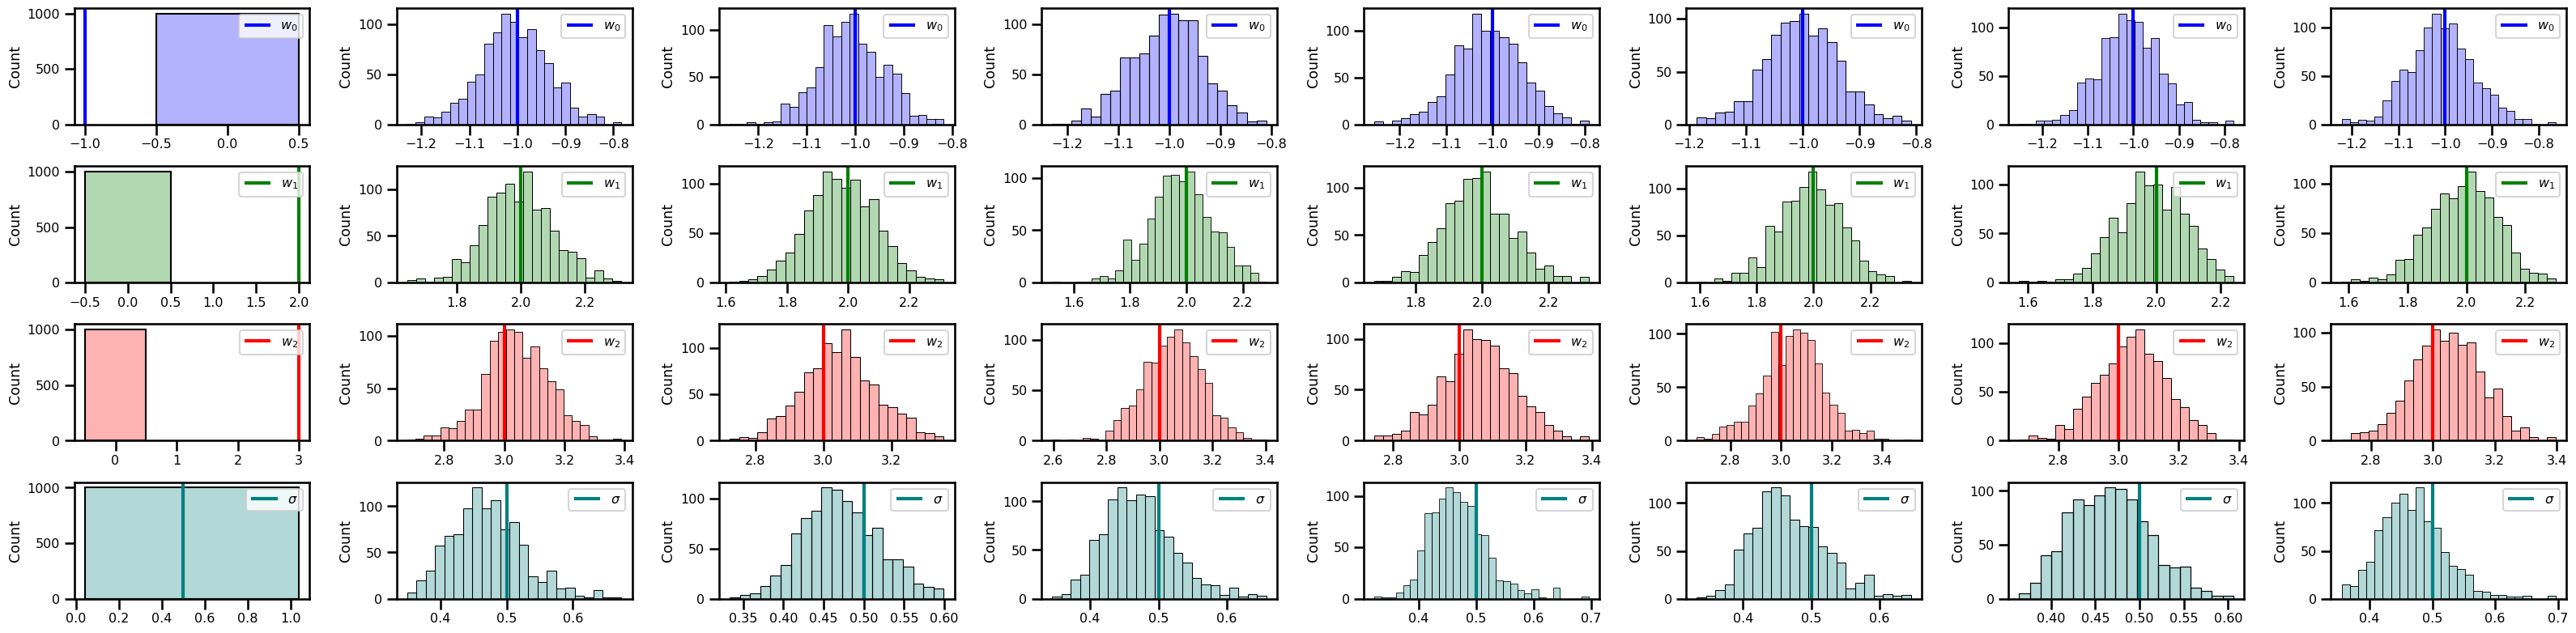

In [15]:
w_chains, sigma_chains = chains

# Trace plots of w (one of 8 chains)
colors = ['b', 'g', 'r', 'teal']
fig, axes = plt.subplots(4, num_chains, figsize=(4 * num_chains, 8))
for j in range(num_chains):
  for i in range(3):
    ax = axes[i][j]
    ax.plot(w_chains[:, j, i], c=colors[i], alpha=.3)
    ax.hlines(true_w[i], 0, 1000, zorder=4, color=colors[i], label="$w_{}$".format(i))
    ax.legend(loc='upper right')
  ax = axes[3][j]
  ax.plot(sigma_chains[:, j], alpha=.3, c=colors[3])
  ax.hlines(noise_scale, 0, 1000, zorder=4, color=colors[3], label=r"$\sigma$".format(i))
  ax.legend(loc='upper right')
fig.tight_layout()
plt.show()

# Histogram of samples of w
fig, axes = plt.subplots(4, num_chains, figsize=(4 * num_chains, 8))
for j in range(num_chains):
  for i in range(3):
    ax = axes[i][j]
    sns.histplot(w_chains[:, j, i], color=colors[i], ax=ax, alpha=0.3) #hist_kws={'alpha': .3})
  for i in range(3):
    ax = axes[i][j]
    ymax = ax.get_ylim()[1]
    ax.vlines(true_w[i], 0, ymax, color=colors[i], label="$w_{}$".format(i), linewidth=3)
    ax.set_ylim(0, ymax)
    ax.legend(loc='upper right')


  ax = axes[3][j]
  sns.histplot(sigma_chains[:, j], color=colors[3], ax=ax, alpha=0.3) #hist_kws={'alpha': .3})
  ymax = ax.get_ylim()[1]
  ax.vlines(noise_scale, 0, ymax, color=colors[3], label=r"$\sigma$".format(i), linewidth=3)
  ax.set_ylim(0, ymax)
  ax.legend(loc='upper right')
fig.tight_layout()
plt.show()

In [66]:
from lattice.gauge_lattice import GaugeLattice
from lattice.utils import get_potential_fn

lattice_shape = (512, 16, 16, 2)

x = tf.random.normal(lattice_shape)
lattice = GaugeLattice(lattice_shape)
beta = 5.

unnormalized_log_prob = get_potential_fn(lattice_shape)
def potential_fn(x):
    return beta * unnormalized_log_prob(x)

def potential_fn_single_lattice(x):
    """Compute the unnormalized log probability of a single lattice.
                     -U[x+nu, mu]
                   +-------<------+
                   |              |
                   |              |  
                   |              |
        - U[x, nu] v              ^ U[x+mu, nu]
                   | ^ nu         |
                   | |            |
                   | +--> mu      |
                   x------->------+
                     U[x, mu]
    """
    x = tf.reshape(x, (16, 16, 2))
    wl = (x[:, :, 0]                                #  U[x, mu]
          - x[:, :, 1]                              # -U[x, nu]
          - tf.roll(x[:, :, 0], shift=-1, axis=1)   # -U[x+nu, mu]
          + tf.roll(x[:, :, 1], shift=-1, axis=0))  #  U[x+mu, nu]
    logprob = tf.reduce_sum(1. - tf.cos(wl), axis=(0, 1))
    
    return beta * logprob


def trace_fn(current_state, previous_kernel_results):
    return current_state, previous_kernel_results


# Apply a simple step size adaptation during burnin
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        tfp.mcmc.HamiltonianMonteCarlo(
            step_size=0.2,
            num_leapfrog_steps=10,
            target_log_prob_fn=potential_fn,
        ),
        num_adaptation_steps=int(num_burnin_steps * 0.8),
    )

    #adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    #    transformed_kernel,
    #    num_adaptation_steps=int(.8 * num_burnin_steps),
    #    target_accept_prob=np.float64(.75))

    return tfp.mcmc.sample_chain(
        num_results=num_results, num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=adaptive_hmc,
        seed=(0, 1),
        trace_fn=trace_fn,
        return_final_kernel_results=True,
        #trace_fn=lambda cs, kr: cs, kr
    )


@tf.function
def run_chain1():
    samples, previous_kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=x,
        kernel=adaptive_hmc,
        trace_fn=trace_fn,
        #lambda current_state, previous_kernel_results
        #trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
    
    return samples, previous_kernel_results


num_results = int(1e4)
num_burnin_steps = int(1e3)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        step_size=0.2,
        num_leapfrog_steps=10,
        target_log_prob_fn=potential_fn,
    ),
    num_adaptation_steps=int(num_burnin_steps * 0.8)
)

In [29]:
num_chains = 16
initial_state = tf.random.normal((512, 16, 16, 2))
output = run_chain(initial_state)

In [31]:
checkpointable_states_and_trace, all_states, states_and_trace = output

In [32]:
type(all_states)

tuple

In [58]:
def calc_lattice_metrics(x, beta):
    wl = lattice.calc_wilson_loops(x)
    q = lattice.calc_both_charges(wloops=wl)
    plaqs = lattice.calc_plaqs(wloops=wl, beta=beta)
    
    return q, plaqs


samples = all_states[0]
qint_arr = []
qsin_arr = []
plaqs_arr = []
for idx, sample in enumerate(samples):
    console.log(f'{idx} / {samples.shape[0]}')
    q, plaqs = calc_lattice_metrics(sample, beta)
    qint_arr.append(q.intQ)
    qsin_arr.append(q.sinQ)
    plaqs_arr.append(plaqs)

In [60]:
qint = tf.convert_to_tensor(qint_arr)
qsin = tf.convert_to_tensor(qsin_arr)
plaqs = tf.convert_to_tensor(plaqs_arr)

In [61]:
qint.shape

TensorShape([1000, 512])

In [64]:
fig, ax = plt.subplots()
ax.plot(plaqs[:, 0], 'k-')

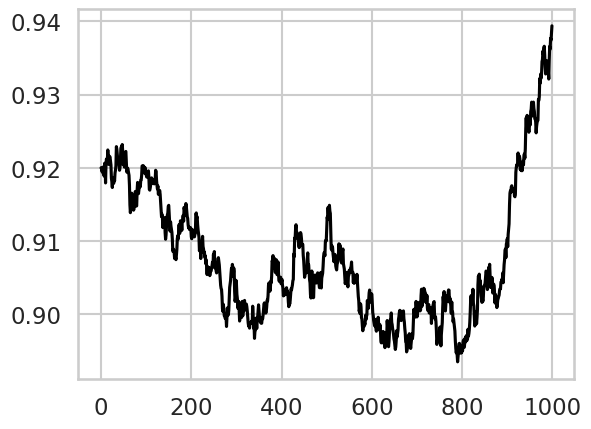

In [65]:
plt.show()

In [34]:
all_states0, all_states1 = all_states

In [44]:
console.log(f'checkpointable_states_and_trace.type = {type(checkpointable_states_and_trace)}')
console.log(f'all_states.type = {type(all_states)}')
console.log(f'states_and_trace.type = {type(states_and_trace)}')

In [45]:
checkpointable_states_and_trace.shape

TensorShape([1000, 512, 16, 16, 2])

In [51]:
console.log(f'{type(all_states[0])}')
console.log(f'{type(all_states[1])}')

In [52]:
all_states[0].shape

TensorShape([1000, 512, 16, 16, 2])

In [54]:
q = lattice.calc_both_charges(x=all_states[0][0])

In [55]:
type(q)

lattice.gauge_lattice.Charges

In [57]:
console.log(q.intQ)

In [53]:
tf.reduce_sum(all_states[0] - checkpointable_states_and_trace)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [38]:
all_states1.

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
  

In [39]:
ssa_results = all_states1

In [42]:
ssa_results.inner_results.accepted_results.

MetropolisHastingsKernelResults(
  accepted_results=UncalibratedHamiltonianMonteCarloKernelResults(
      log_acceptance_correction=<tf.Tensor: shape=(1000, 512, 16, 16), dtype=float32, numpy=
        array([[[[0., 0., 0., ..., 0., 0., 0.],
                 [0., 0., 0., ..., 0., 0., 0.],
                 [0., 0., 0., ..., 0., 0., 0.],
                 ...,
                 [0., 0., 0., ..., 0., 0., 0.],
                 [0., 0., 0., ..., 0., 0., 0.],
                 [0., 0., 0., ..., 0., 0., 0.]],
        
                [[0., 0., 0., ..., 0., 0., 0.],
                 [0., 0., 0., ..., 0., 0., 0.],
                 [0., 0., 0., ..., 0., 0., 0.],
                 ...,
                 [0., 0., 0., ..., 0., 0., 0.],
                 [0., 0., 0., ..., 0., 0., 0.],
                 [0., 0., 0., ..., 0., 0., 0.]],
        
                [[0., 0., 0., ..., 0., 0., 0.],
                 [0., 0., 0., ..., 0., 0., 0.],
                 [0., 0., 0., ..., 0., 0., 0.],
                 ...,
 

In [30]:
len(output)

3

In [8]:

# Instead of a single set of initial w's, we create a batch of 8.
num_chains = 8
initial_state = [np.zeros([num_chains, num_features + 1]),
                 .54 * np.ones([num_chains], dtype=np.float64)]

chains, kernel_results = run_chain(initial_state)

r_hat = tfp.mcmc.potential_scale_reduction(chains)
print("Acceptance rate:", kernel_results.inner_results.inner_results.is_accepted.numpy().mean())
print("R-hat diagnostic (per w variable):", r_hat[0].numpy())
print("R-hat diagnostic (sigma):", r_hat[1].numpy())

In [9]:
x.shape

TensorShape([512, 16, 16, 2])

In [10]:
pe = potential_fn(x)

In [12]:
pe.shape

TensorShape([512, 16, 16])

In [ ]:
from lattice.utils import get_potential_fn
help(get_po)